In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [14]:
'''Data Cleaning'''
# Loading Data
order_payment_dataset = pd.read_csv('./order_payments_dataset.csv')
orders_dataset = pd.read_csv('./orders_dataset.csv')
customer_reviews_dataset = pd.read_csv('./customer_reviews_dataset.csv')
customers_dataset = pd.read_csv('./customers_dataset.csv')
order_items_dataset = pd.read_csv('./order_items_dataset.csv')
products_dataset = pd.read_csv('./products_dataset.csv')
sellers_dataset = pd.read_csv('./sellers_dataset.csv')
geo_dataset = pd.read_csv('./Clean_geodata.csv')
geo_dataset.info()
#link to Clean_geodata: https://drive.google.com/file/d/1ZsuJWBLdsbfWI7GQNgKMZj-a1bh2wDK_/view?usp=sharing

#Dataset Transformation
#1. geo-dataset transdormation:
geo_dataset_seller = geo_dataset #seller zipcode dataset
geo_dataset_seller.rename(columns = {'region1':'region1_seller', 'region2':'region2_seller', 
                              'region3':'region3_seller','latitude':'latitude_seller','longitude':'longitude_seller'}, inplace = True) 
geo_dataset = pd.read_csv('./Clean_geodata.csv')
geo_dataset_consumer = geo_dataset #consumer zipcode dataset
geo_dataset_consumer.rename(columns = {'region1':'region1_con', 'region2':'region2_con', 
                              'region3':'region3_con','latitude':'latitude_con','longitude':'longitude_con'}, inplace = True) 
#2.seller and consumer zip code transform
sellers_dataset['seller_zip_code_prefix'] = sellers_dataset['seller_zip_code_prefix'].astype(int)
customers_dataset['customer_zip_code_prefix'] = customers_dataset['customer_zip_code_prefix'].astype(int)

# Merge Dataset 
final=order_payment_dataset.merge(orders_dataset,on='order_id',how = 'left')
final=final.merge(customer_reviews_dataset,how = 'left',on='order_id')
final=final.merge(customers_dataset,how = 'left',on='customer_id')
final=final.merge(order_items_dataset,how = 'left',on='order_id')
final=final.merge(products_dataset,how = 'left',on='product_id')
final=final.merge(sellers_dataset,how = 'left',on='seller_id')
final=final.merge(geo_dataset_seller,how = 'left',left_on='seller_zip_code_prefix',right_on='postcode')
final=final.merge(geo_dataset_consumer,how = 'left',left_on='customer_zip_code_prefix',right_on='postcode')
#print(final.shape)
#final.isnull().sum()

#genertate sell-con Euclidean_dist
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km
final['Eucl'] = [haversine(final.longitude_seller[i],final.latitude_seller[i],final.longitude_con[i],final.latitude_con[i]) for i in range(len(final))]

# Extract survey review data
survey_review_data = final[['order_id','survey_score','survey_review_title','survey_review_content']]
final = final.drop(['survey_review_title','survey_review_content','postcode_x','postcode_y'],axis=1)
#drop null values: clean dataset, good for analysis
final.dropna(inplace=True)

# Clean time variable
final['order_approved_at'] = pd.to_datetime(final['order_approved_at'])
final['order_customer_delivery_date'] = pd.to_datetime(final['order_customer_delivery_date'])
final['shipping_limit_date'] = pd.to_datetime(final['shipping_limit_date'])
final['order_estimated_delivery_date'] = pd.to_datetime(final['order_estimated_delivery_date'])

final['days']=(final['order_customer_delivery_date'].subtract(final['order_approved_at'])).dt.total_seconds() / (3600 * 24)
final['shipping_limit_days']=(final['shipping_limit_date'].subtract(final['order_approved_at'])).dt.total_seconds() / (3600 * 24)
final['estimated_days']=(final['order_estimated_delivery_date'].subtract(final['order_approved_at'])).dt.total_seconds() / (3600 * 24)
# a limit for sellers to send their products to the logistics
#negative values means delivered before the order [they are outliers, should be deleted]
final = final[final['days'].notna()]
final['delivery_state']=(final['order_estimated_delivery_date']).subtract(final['order_customer_delivery_date']).dt.total_seconds() / (3600 * 24)
#negative: delayed, positive: pre deliverd

#drop null values: clean dataset
final.dropna(inplace=True)

# aggregate product information
order_mass = final[['order_id','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
order_mass['product_mass'] = order_mass['product_length_cm'] * order_mass['product_height_cm'] * order_mass['product_width_cm']
order_mass = order_mass[['order_id','product_mass','product_weight_g']]
order_mass = order_mass.groupby('order_id')['product_mass','product_weight_g'].sum()
order_mass = order_mass.rename(columns={"order_id": "order_id", "product_mass": "order_mass", "product_weight_g": "order_weight_g"})
final=final.merge(order_mass,how = 'left',on='order_id')

# Clean distance between sellers and customers
final['distance']= 0

for i in range(final.shape[0]):
    if final['region3_seller'][i]==final['region3_con'][i]:
        final['distance'][i]=1
    elif final['region2_seller'][i]==final['region2_con'][i]:
        final['distance'][i]=2
    elif final['region1_seller'][i]==final['region1_con'][i]:
        final['distance'][i]=3
    else: 
        final['distance'][i]=4

# 1: same region 3
# 2: same region 2, not same region 3
# 3: same region 1, not same region 2
# 4: not same region 1

# Add a new column "Category" to classified products into 10 categories
baby=['bebes','brinquedos','fraldas_higiene','fashion_roupa_infanto_juvenil']
commerce=['agro_industria_e_comercio','industria_comercio_e_negocios']
food_drinks=['la_cuisine','bebidas','alimentos','market_place','alimentos_bebidas']
fashion=['flores','livros_importados','fashion_roupa_feminina','fashion_esporte','fashion_underwear_e_moda_praia','fashion_roupa_masculina','malas_acessorios','relogios_presentes','fashion_calcados','fashion_bolsas_e_acessorios']
home_and_office=['utilidades_domesticas','casa_conforto','artigos_de_natal','artigos_de_festas','casa_conforto_2','portateis_casa_forno_e_cafe','papelaria','pet_shop','construcao_ferramentas_construcao','construcao_ferramentas_ferramentas','ferramentas_jardim','construcao_ferramentas_jardim','casa_construcao','construcao_ferramentas_iluminacao','construcao_ferramentas_seguranca','sinalizacao_e_seguranca','seguros_e_servicos']
sport_and_entertainment=['musica','cine_foto','artes_e_artesanato','cool_stuff','livros_importados','livros_interesse_geral','artes','dvds_blu_ray','cds_dvds_musicais','instrumentos_musicais','esporte_lazer']
furniture=['cama_mesa_banho','moveis_cozinha_area_de_servico_jantar_e_jardim','moveis_decoracao','moveis_escritorio','moveis_colchao_e_estofado','moveis_sala','moveis_quarto']
auto=['automotivo']
beauty=['beleza_saude','perfumaria']
electric_appliance=['informatica_acessorios','telefonia','tablets_impressao_imagem','telefonia_fixa','eletroportateis','consoles_games','audio','climatizacao','eletronicos','eletrodomesticos','livros_tecnicos','pcs','eletrodomesticos_2']

Category = []
NaN = np.nan
final['Category']=NaN
i = 0
for c in final['product_category_name']:
    for x in baby: 
        if c == x: 
             #  Category.append('Baby')
            final.Category.iloc[i]='Baby'
    for x in commerce:
        if c == x:
            final.Category.iloc[i]='Commerce'
    for x in food_drinks:
        if c == x:
            final.Category.iloc[i]='Food_drinks'
    for x in fashion:
        if c == x:
            final.Category.iloc[i]='Fashion'
    for x in home_and_office:
        if c == x:
            final.Category.iloc[i]='Home_and_office'
    for x in sport_and_entertainment:
        if c == x:
            final.Category.iloc[i]='Sports_and_entertainment'
    for x in furniture:
        if c == x:
            final.Category.iloc[i]='Furniture'
    for x in auto:
        if c == x:
            final.Category.iloc[i]='Auto'
    for x in beauty:
        if c == x:
            final.Category.iloc[i]='Beauty'
    for x in electric_appliance:
        if c == x:
            final.Category.iloc[i]='Electric_appliance'
    i = i+1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23839 entries, 0 to 23838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   postcode   23839 non-null  int64  
 1   region1    23839 non-null  object 
 2   region2    23839 non-null  object 
 3   region3    23839 non-null  object 
 4   latitude   23839 non-null  float64
 5   longitude  23839 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

feature columns: 
Index(['payment_value', 'price', 'freight_value', 'Eucl',
       'shipping_limit_days', 'estimated_days', 'order_mass', 'order_weight_g',
       'distance'],
      dtype='object')

(22764, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Eucl,estimated_days,pre_days,days
81576,371.860350,22.0,13.0,5.0
93075,816.399684,21.0,11.0,12.0
12110,1009.528584,26.0,7.0,7.0
99057,734.199506,23.0,14.0,5.0
50779,3184.634332,46.0,21.0,19.0
77989,1446.609525,40.0,23.0,13.0
94593,255.830694,38.0,14.0,17.0
56084,143.736180,23.0,11.0,12.0
52157,117.716922,15.0,8.0,3.0
11655,520.488856,28.0,16.0,10.0


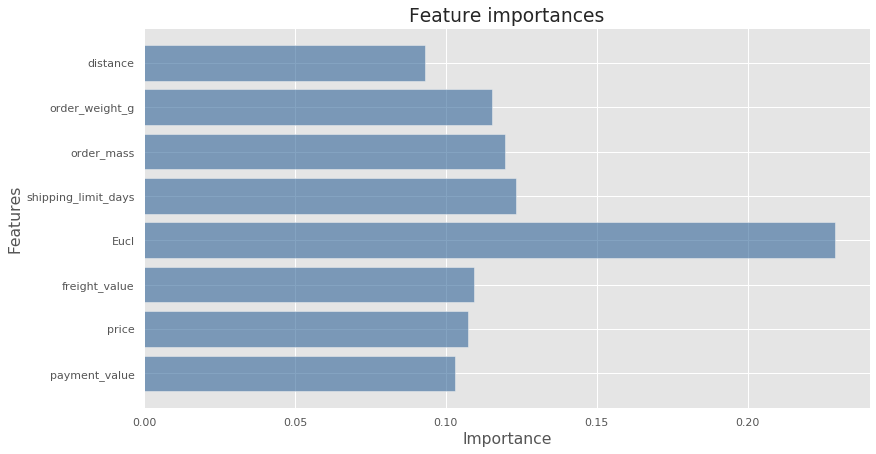

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to b

,Eucl,estimated_days,pre_days,days,better,accurate_pre,accurate_exp
81576,371.860350,22.0,13.0,5.0,1,0,0
93075,816.399684,21.0,11.0,12.0,0,0,0
12110,1009.528584,26.0,7.0,7.0,1,1,0
99057,734.199506,23.0,14.0,5.0,1,0,0
50779,3184.634332,46.0,21.0,19.0,1,0,0
77989,1446.609525,40.0,23.0,13.0,1,0,0
94593,255.830694,38.0,14.0,17.0,0,0,0
56084,143.736180,23.0,11.0,12.0,0,0,0
52157,117.716922,15.0,8.0,3.0,1,0,0
11655,520.488856,28.0,16.0,10.0,1,0,0


0    17255
1     5509
Name: accurate_pre, dtype: int64 1:pre is accurate,0:pre is not acc
0    22421
1      343
Name: accurate_exp, dtype: int64 1:exp is accurate,0:exp is not acc
1    15899
0     6591
Name: better, dtype: int64 1:prediction is better,0:expected is better
proportion of 1 0.706936416184971


In [15]:
'''Regressor'''

# prepare feature, labels & train test set
final_regression= final.drop(['order_id','payment_sequential','payment_type','payment_installments','customer_id', 'order_status','order_purchase_timestamp', 'order_approved_at','order_carrier_delivery_date', 'order_customer_delivery_date','order_estimated_delivery_date', 'review_id','survey_score','survey_send_date', 'survey_completion_date', 'customer_unique_id','customer_zip_code_prefix', 'customer_city', 'customer_state','order_item_id', 'product_id', 'seller_id', 'product_category_name','product_name_lenght', 'product_description_lenght','product_photos_qty', 'product_weight_g', 'product_length_cm','product_height_cm', 'product_width_cm', 'seller_zip_code_prefix','seller_city', 'seller_state', 'region1_seller', 'region2_seller','region3_seller', 'region1_con', 'region2_con', 'region3_con','shipping_limit_date','latitude_seller','longitude_seller','latitude_con','longitude_con','delivery_state','Category'],axis=1)
features, label = final_regression.drop(['days'], axis=1), final_regression['days']
print(f"feature columns: \n{features.columns}\n")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=30)
X_train2 = X_train.drop(['estimated_days'], axis=1)
X_test2 = X_test.drop(['estimated_days'], axis=1)
featurecolumn = X_test2.columns
print(X_test2.shape)

# Extratrees Regressor
from sklearn.ensemble import ExtraTreesRegressor
regr = ExtraTreesRegressor()
regr.fit(X_train2, y_train)
ypred = regr.predict(X_test2)
X_test['pre_days'] = ypred
X_test['days'] = y_test
result = X_test.drop(['payment_value','price','freight_value','shipping_limit_days','order_mass','order_weight_g','distance'],axis=1)

result['estimated_days'] = result['estimated_days'].add(.5).round()
result['pre_days'] = result['pre_days'].add(.5).round()
result['days'] = result['days'].add(.5).round()
display(result.head(10))

#Feature Importance
importances = regr.feature_importances_
plt.figure(figsize=(13,7))
plt.rcParams.update({'font.size': 13})
plt.barh(range(len(regr.feature_importances_)), regr.feature_importances_, tick_label = featurecolumn,color=(0.2, 0.4, 0.6, 0.6))
plt.title("Feature importances")
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

# comparation: accurate? better?
result['better'] = 0
result.index.tolist()

for i in result.index.tolist():
    if result['pre_days'][i] <= result['days'][i] and result['pre_days'][i] > result['estimated_days'][i]:
        result['better'][i] = 1
    
    elif result['pre_days'][i] >= result['days'][i] and result['pre_days'][i] < result['estimated_days'][i]:
        result['better'][i] = 1
        
    elif result['pre_days'][i] >= result['days'][i] and result['estimated_days'] [i] < result['days'][i]:
        result['better'][i] = 1
        
    elif result['pre_days'][i] == result['estimated_days'][i]:
        result['better'][i] = 2

result_filtered = result[result['better'] < 2] 

result['accurate_pre'] = 0
result.index.tolist()

for i in result.index.tolist():
    if result['pre_days'][i] == result['days'][i]:
        result['accurate_pre'][i] = 1

result['accurate_exp'] = 0
result.index.tolist()

for i in result.index.tolist():
    if result['estimated_days'][i] == result['days'][i]:
        result['accurate_exp'][i] = 1
        
display(result.head(20))
print(result['accurate_pre'].value_counts(),'1:pre is accurate,0:pre is not acc')
print(result['accurate_exp'].value_counts(),'1:exp is accurate,0:exp is not acc')
print(result_filtered['better'].value_counts(),'1:prediction is better,0:expected is better')
print('proportion of 1',sum(result_filtered['better'])/result_filtered.shape[0])

In [16]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


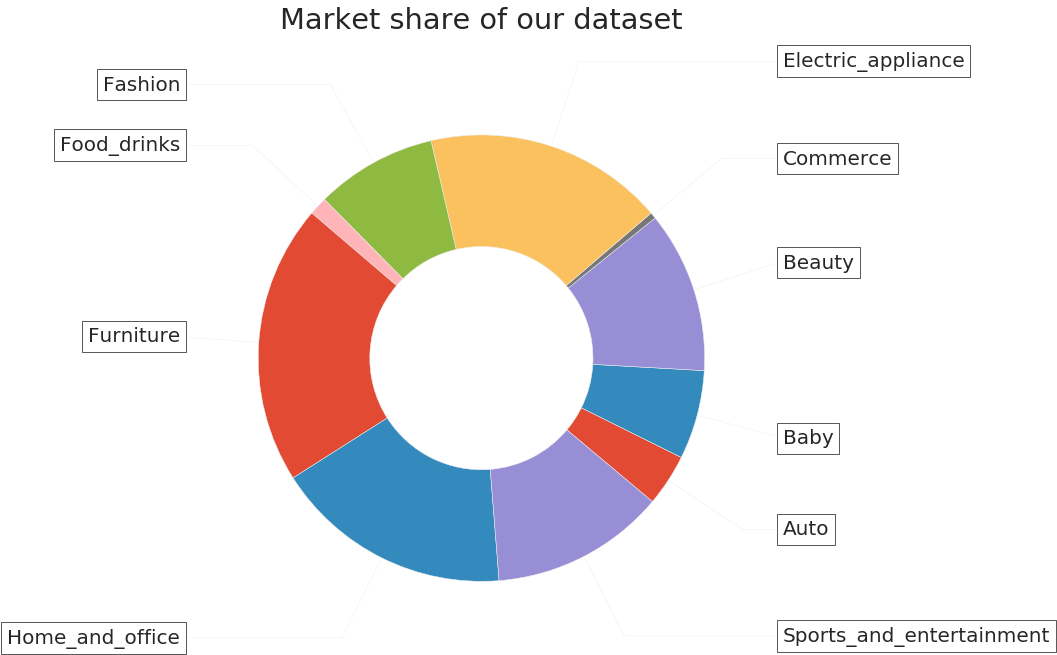

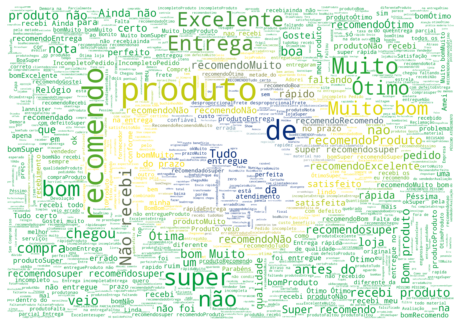

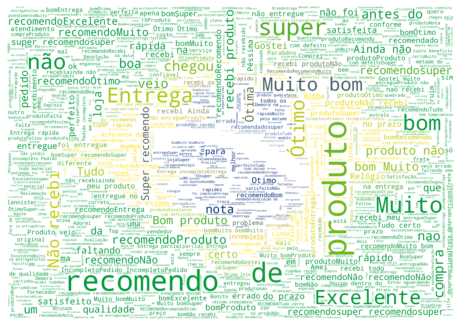

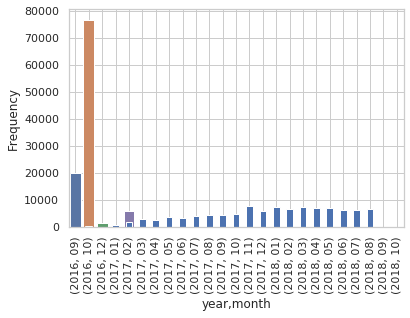

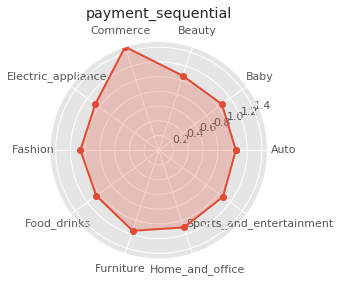

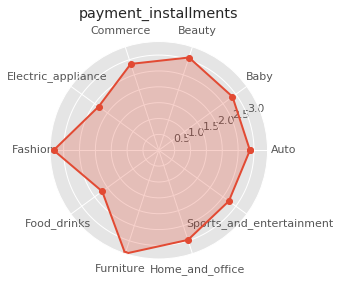

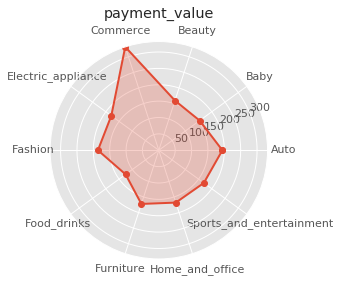

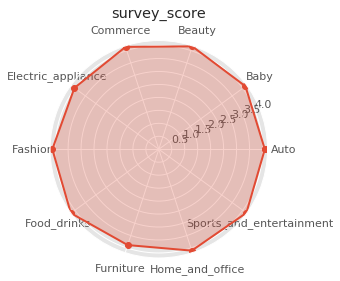

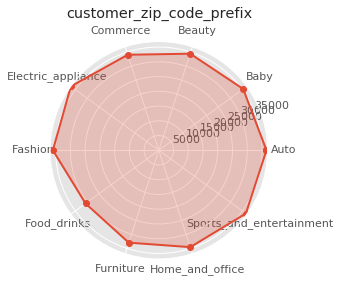

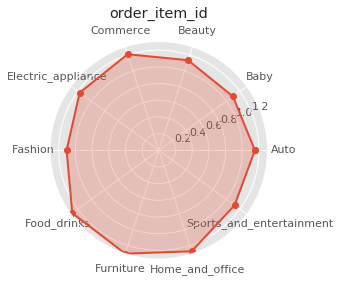

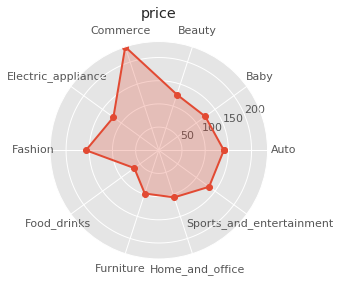

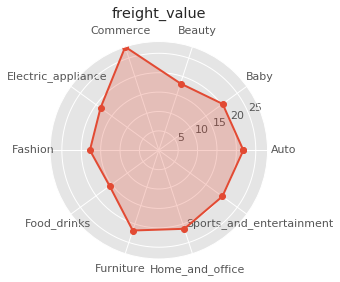

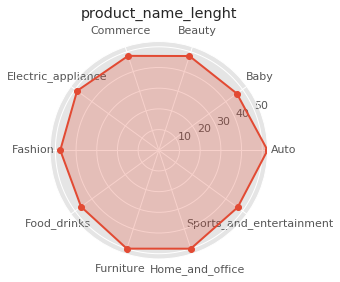

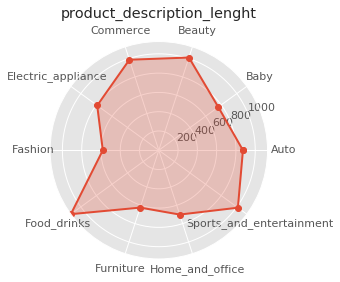

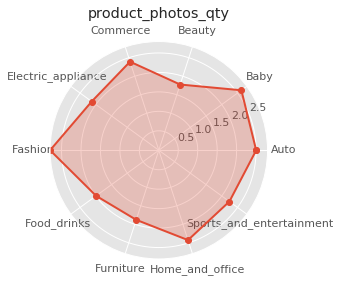

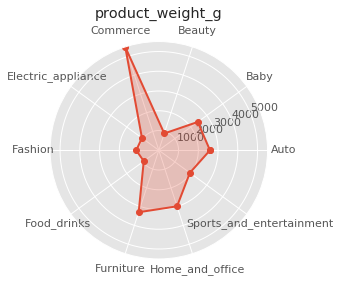

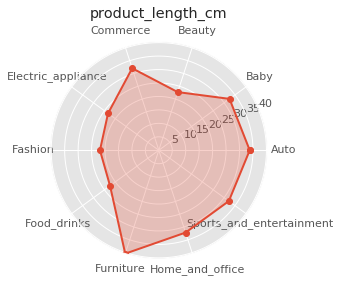

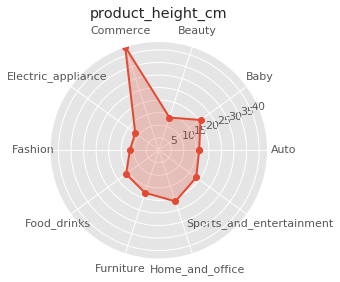

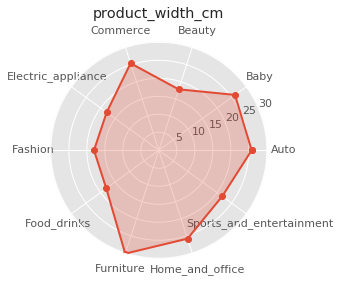

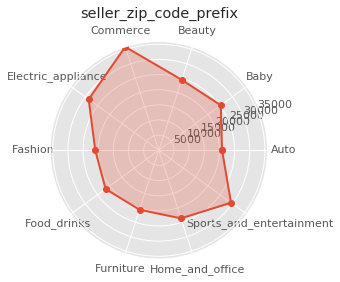

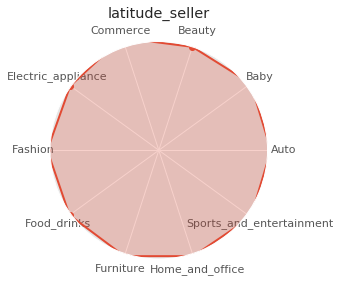

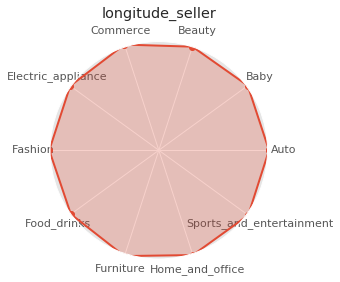

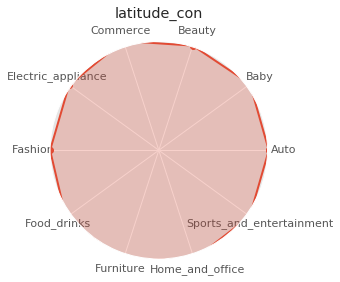

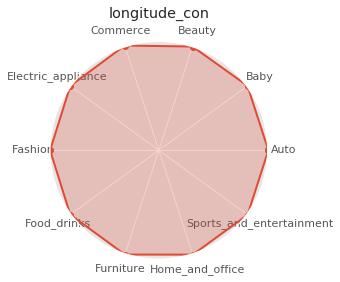

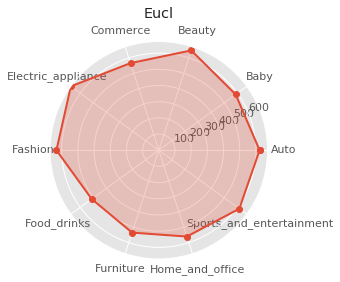

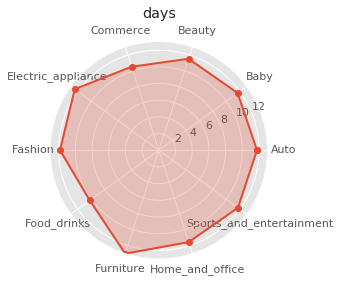

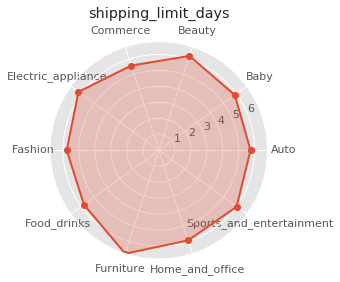

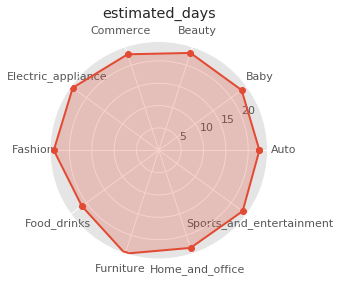

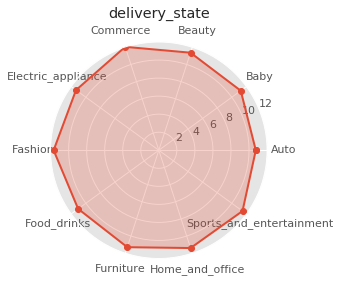

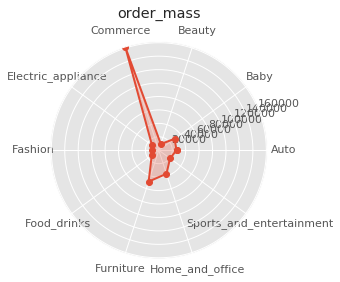

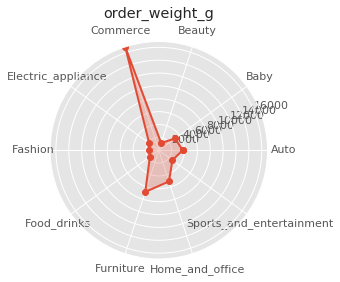

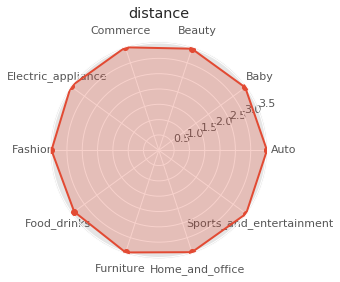

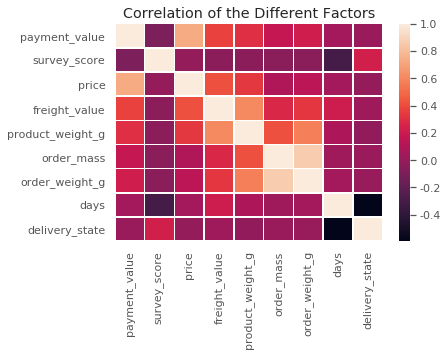

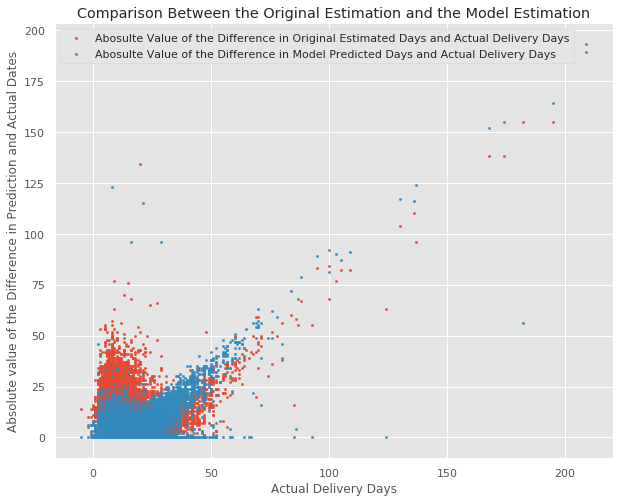

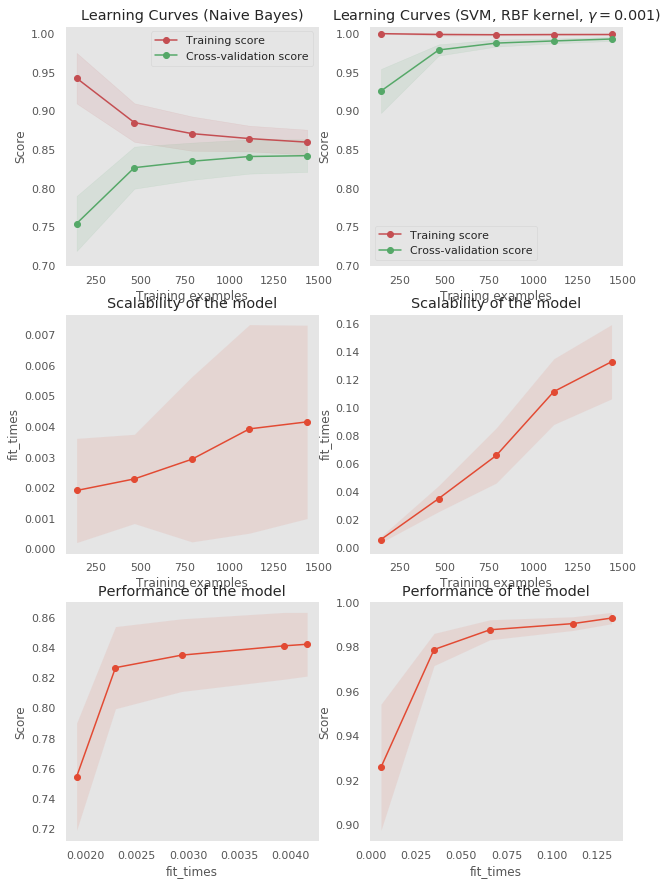

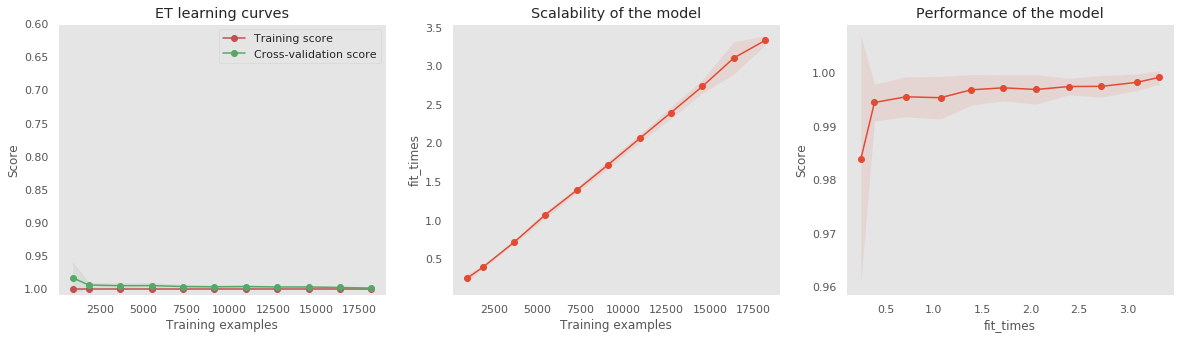

In [18]:
'''Data Description'''
df_order_by_category=final[['product_id','Category']].groupby('Category').count()
df_order_by_category.rename(columns={'product_id':'product_count'},inplace=True)
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))

Name = list(df_order_by_category.index)

data = list(df_order_by_category.product_count)

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, textprops={'fontsize': 10})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(Name[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Market share of our dataset",y=1.08)

plt.show()

## --Graph 2: show the customer review (title/contents) key words of orders-------------
# import basic

import os
from os import path
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


# create txt for customer review title & contents
import csv
survey_review_data.to_csv('survey_review_data.csv')

review_contents = pd.DataFrame(survey_review_data['survey_review_content'])
review_contents.dropna(inplace=True)

review_title = pd.DataFrame(survey_review_data['survey_review_title'])
review_title.dropna(inplace=True)

review_title.to_csv('review_title.txt', index=False)
review_contents.to_csv('review_contents.txt', index=False)

text_title = open("review_title.txt",encoding='utf8').read()
text_title = text_title.replace('\n',"").replace("\u3000","")

text_contents = open("review_contents.txt",encoding='utf8').read()
text_contents = text_title.replace('\n',"").replace("\u3000","")

# create word cloud
mask = np.array(Image.open("Brazil-flag.png"))
wordcloud_contents = WordCloud(background_color="white", max_words=1000, mask=mask).generate(text_contents)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud_contents.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("contents_flag", format="png")
plt.show()


wordcloud_title = WordCloud(background_color="white", max_words=1000, mask=mask).generate(text_title)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud_title.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("title_flag", format="png")
plt.show()

#reference: https://www.datacamp.com/community/tutorials/wordcloud-python

## --Graph 3: order payment method-------------
order_payment_dataset = pd.read_csv('./order_payments_dataset.csv')
order_payment_dataset.describe()
payment_type=order_payment_dataset.groupby('payment_type').count()
payment_type.rename(columns={'order_id':'Frequency'},inplace=True)
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.barplot(x=list(payment_type.index), y='Frequency', data=payment_type)
### credit card is the most frequently used method to pay online

## --Graph 4: measuring the selling situation-------------
orders_dataset = pd.read_csv('./orders_dataset.csv')
orders_dataset['year']=orders_dataset['order_purchase_timestamp'].apply(lambda x: x[:4])
orders_dataset['month']=orders_dataset['order_purchase_timestamp'].apply(lambda x: x[5:7])
sale_month_year=orders_dataset.groupby(['year','month']).count()
sale_month_year.rename(columns={'order_id':'Frequency'},inplace=True)
sale_month_year=sale_month_year['Frequency']
sale_month_year.plot.bar()
# it has a increase tendency and Nov, 2017 is the month with most sales. 


## --Graph 4: showing the feature of each Category-------------
pro_describ=final.groupby('Category').mean()
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')

featurelist=list(pro_describ.index)
Category=list(pro_describ.columns)


for i in range(len(Category)):
    values = list(pro_describ[Category[i]])
    feature = featurelist
    N = len(values)
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    values=np.concatenate((values,[values[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, feature)
    ax.set_ylim(0,max(values))
    plt.title(str(Category[i]),y=1.08)
    ax.grid(True)
    plt.show()

# Graph 7
import seaborn as sns 
heat_corr = final[['payment_value','survey_score','price','freight_value','product_weight_g','order_mass','order_weight_g','days','delivery_state']]
correlation_matrix = heat_corr.corr()

ax = sns.heatmap(correlation_matrix, linewidth=0.5) 
ax.set_title('Correlation of the Different Factors')
plt.show()


##Graph 8
days=result['days']
preday_actual=result['preday_actual']=result['pre_days']-result['days']
result.head(2)
estimated_actual=result['estimated_actual']=result['estimated_days']-result['days']
result.head(2)

preact=result['preday_actual'].abs()
estiact=result['estimated_actual'].abs()

plt.figure(figsize=(10,8))
est = plt.scatter(days,estiact, marker='o', s=5.0)
pre = plt.scatter(days,preact, marker='o', s=5.0)
plt.legend(handles=[est, pre], labels=['Abosulte Value of the Difference in Original Estimated Days and Actual Delivery Days', 'Abosulte Value of the Difference in Model Predicted Days and Actual Delivery Days'])
plt.xlabel('Actual Delivery Days')
plt.ylabel('Absolute value of the Difference in Prediction and Actual Dates')
plt.title('Comparison Between the Original Estimation and the Model Estimation')
plt.show()

# Graph 9
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()


g = plot_learning_curve(ExtraTreesRegressor(random_state=10),
                        "ET learning curves", X_test, y_test, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

